# Generate Training Points

Forked from https://github.com/frontiersi/FAO_LC_workshop_Rwanda/blob/main/0_Generate_Training_Points.ipynb and https://github.com/auspatious/ldn-lulc/blob/main/notebooks/Compare_LULC_per_class.ipynb

## Background

**Training data** is the most important part of any supervised machine learning workflow. The quality of the training data has a greater impact on the classification than the algorithm used. Large and accurate training data sets are preferable: increasing the training sample size results in increased classification accuracy ([Maxell et al 2018](https://www.tandfonline.com/doi/full/10.1080/01431161.2018.1433343)).  A review of training data methods in the context of Earth Observation is available [here](https://www.mdpi.com/2072-4292/12/6/1034).

There are many platforms to use for gathering land cover training labels, the best one to use depends on your application. GIS platforms are great for collecting training data as they are highly flexible and mature platforms; [Geo-Wiki](https://www.geo-wiki.org/) and [Collect Earth Online](https://collect.earth/home) are two open-source websites that may also be useful depending on the reference data strategy employed. Alternatively, there are many pre-existing training datasets on the web that may be useful, e.g. [Radiant Earth](https://www.radiant.earth/) manages a growing number of reference datasets for use by anyone. With locations of land cover labels available, we can extract features at these locations from satellite imagery as input for machine learning.  

## Description

As timely training data is not always available, in this notebook we demonstrate how to generate a set of randomly distributed training points for a selected district in Rwanda from an existing classification map.

The workflow includes the following steps:

1. Preview the district boundaries of Rwanda on a basemap
2. Select a district as area of analysis
3. Merging classes on the classification map to keep only those you want
4. Generate randomly distributed training points and export for future use

***

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

Note: The approximate running time for the default setting is about 2 minutes.

### Load packages


In [20]:
%matplotlib inline
import warnings
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap,BoundaryNorm
from matplotlib.patches import Patch
from random_sampling import random_sampling # adapted from function by Chad Burton: https://gist.github.com/cbur24/04760d645aa123a3b1817b07786e7d9f
from datacube.utils.cog import write_cog
from odc.geo import BoundingBox
import yaml


from pystac.client import Client
from odc.stac import load
from planetary_computer import sign_url
import rasterio
from scipy.ndimage import uniform_filter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys
import os
sys.path.append(os.path.abspath(".."))
from src.Compare_LULC_func import standardise_class

In [21]:
# Reload functions during development
%load_ext autoreload
%autoreload 2

In [22]:
datetime = '2020-06'
lulc_class_raster=f'singapore_worldcover_{datetime}_100m.tif'
output_crs='epsg:32648' # WGS84/UTM Zone 48N for Singapore

with open("typology_mapping.yaml") as f:
    typology_mapping = yaml.safe_load(f)

bbox = BoundingBox(
    # TODO: Viti Levu, Fiji
    
    # Singapore
    left=103.6,
    bottom=1.2,
    right=104.1,
    top=1.48,
    crs="EPSG:4326",
)
bbox.explore()

In [23]:
print(typology_mapping.keys())
print(typology_mapping['classes'])
print(typology_mapping['colours'])

world_cover_map = typology_mapping['world_cover_map']
print(type(world_cover_map))
print(world_cover_map)

dict_keys(['classes', 'colours', 'cci_lc_map', 'world_cover_map', 'io_map'])
{'No data': 0, 'Tree': 1, 'Grassland': 2, 'Cropland': 3, 'Wetland': 4, 'Built-up': 5, 'Other land': 6, 'Water': 7}
{0: 'white', 1: 'darkgreen', 2: 'limegreen', 3: 'lime', 4: 'turquoise', 5: 'gray', 6: 'yellow', 7: 'blue'}
<class 'dict'>
{80: 7, 10: 1, 20: 2, 30: 2, 40: 3, 50: 5, 60: 6, 70: 6, 90: 4, 95: 4, 100: 6}


## Use ESA Worldcover as data.
In future combine this with other LU/LC products to check agreement (use https://github.com/auspatious/ldn-lulc/blob/main/notebooks/Compare_LULC_per_class.ipynb)

In [24]:
# Use Planetary Computer STAC API
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1/")

# A generic function to load a product given the boundary
def load_lulc_data(product: str, resolution = 100):
    items = catalog.search(
        collections=[product],
        intersects=bbox.polygon,
        datetime=datetime,
    ).item_collection()

    print(f"Found {len(items)} items for product {product}")

    ds = load(
        items,
        intersects=bbox.polygon,
        crs="EPSG:6933", # TODO: Use output_crs 
        groupby="solar_day",
        resolution=resolution,
        chunks={"x": 2048, "y": 2048},
        patch_url=sign_url,
        resample_alg="nearest",
    )

    print(f"Product {product} has variables: {ds.data_vars}")
    return ds

In [25]:
# TODO: Also add other products to ensure agreement between many products.
# cci_da = load_lulc_data('esa-cci-lc', resolution=300)

# vars = list(cci_da.data_vars)
# cci_da["esa_cci_lc"] = cci_da["lccs_class"]
# ds_tmp = cci_da.drop_vars(vars)
# cci_da = ds_tmp.squeeze().load() # removes any singleton dimension and then load the full data

# # Limit the product within the administrative boundary (mainly for removing the water body)
# region_gdf = gdf.to_crs(epsg=6933)
# data = cci_da.rio.write_crs("EPSG:6933")
# geom = region_gdf.geometry.values
# cci_da = data.rio.clip(geom, region_gdf.crs)

In [26]:
wc_da = load_lulc_data('esa-worldcover', resolution=10)

vars = list(wc_da.data_vars)
wc_da["esa_worldcover"] = wc_da["map"]
ds_tmp = wc_da.drop_vars(vars)
wc_da = ds_tmp.squeeze().load() #removes any singleton dimension and then load the full data

wc_da

# # Reproject WorldCover to match CCI resolution using majority vote
# wc_300m = wc_da.rio.reproject_match(
#     cci_da,
#     resampling=rasterio.enums.Resampling.mode   # majority vote (the value that appears most often)
# )

# Limit the product within the administrative boundary (mainly for removing the water body)
# singapore_polygon_6933 = singapore_polygon.to_crs(epsg=6933)
# data = wc_da.rio.write_crs("EPSG:6933")
# geom = singapore_polygon_6933.geometry.values
# wc_300m = data.rio.clip(geom, singapore_polygon_6933.crs)

Found 1 items for product esa-worldcover
Product esa-worldcover has variables: Data variables:
    map              (time, y, x) uint8 17MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    input_quality.1  (time, y, x) int16 34MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    input_quality.2  (time, y, x) int16 34MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    input_quality.3  (time, y, x) int16 34MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>


<xarray.Dataset> Size: 17MB
Dimensions:         (y: 3572, x: 4826)
Coordinates:
  * y               (y) float64 29kB 1.888e+05 1.888e+05 ... 1.531e+05 1.531e+05
  * x               (x) float64 39kB 9.996e+06 9.996e+06 ... 1.004e+07 1.004e+07
    spatial_ref     int32 4B 6933
    time            datetime64[ns] 8B 2020-01-01
Data variables:
    esa_worldcover  (y, x) uint8 17MB 30 50 40 50 50 50 50 ... 80 80 80 80 80 80

In [27]:
# Standardise the classes to match the typology

# cci_da['esa_cci_lc'] = standardise_class(cci_da['esa_cci_lc'], cci_lc_map)
# wc_300m['esa_worldcover'] = standardise_class(wc_300m['esa_worldcover'], world_cover_map)
# io_300m['io_lulc'] = standardise_class(io_300m['io_lulc'], io_map)
wc_da['esa_worldcover'] = standardise_class(wc_da['esa_worldcover'], world_cover_map)
wc_da


<xarray.Dataset> Size: 17MB
Dimensions:         (y: 3572, x: 4826)
Coordinates:
  * y               (y) float64 29kB 1.888e+05 1.888e+05 ... 1.531e+05 1.531e+05
  * x               (x) float64 39kB 9.996e+06 9.996e+06 ... 1.004e+07 1.004e+07
    spatial_ref     int32 4B 6933
    time            datetime64[ns] 8B 2020-01-01
Data variables:
    esa_worldcover  (y, x) uint8 17MB 2 5 3 5 5 5 5 5 5 5 ... 7 7 7 7 7 7 7 7 7

In [28]:
# Write as tiff.
wc_da.rio.to_raster(lulc_class_raster, dtype='uint8', compress='deflate')

# Read the tiff
classification_map=xr.open_dataset(lulc_class_raster,engine="rasterio").astype(np.uint8)
classification_map=classification_map.to_array().squeeze()
classification_map

<xarray.DataArray (y: 3572, x: 4826)> Size: 17MB
array([[2, 5, 3, ..., 4, 4, 4],
       [2, 5, 5, ..., 4, 1, 1],
       [2, 5, 5, ..., 1, 1, 1],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]], shape=(3572, 4826), dtype=uint8)
Coordinates:
  * y            (y) float64 29kB 1.888e+05 1.888e+05 ... 1.531e+05 1.531e+05
  * x            (x) float64 39kB 9.996e+06 9.996e+06 ... 1.004e+07 1.004e+07
    band         int64 8B 1
    spatial_ref  int64 8B ...
    variable     <U9 36B 'band_data'

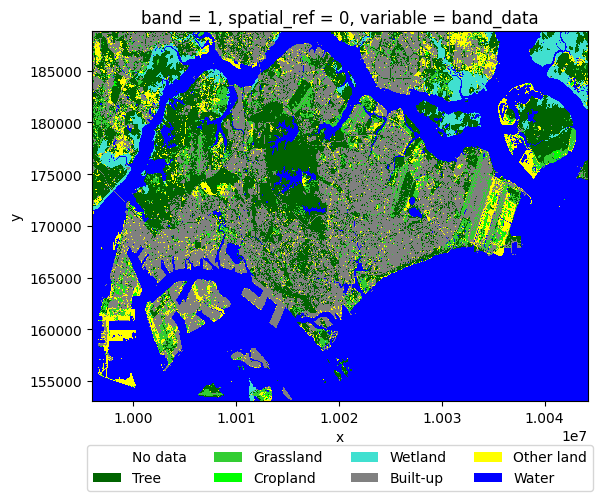

In [29]:
classes = typology_mapping['classes']

colours = typology_mapping['colours']

fig, axes = plt.subplots(1,1)

# Plot classification map
unique_values=np.unique(classification_map)
cmap=ListedColormap([colours[k] for k in unique_values])
norm = BoundaryNorm(list(unique_values)+[np.max(unique_values)+1], cmap.N)
classification_map.plot.imshow(ax=axes, 
                   cmap=cmap,
                   norm=norm,
                   add_labels=True, 
                   add_colorbar=False,
                   interpolation='none')
# add colour legend
patches_list=[Patch(facecolor=colour) for colour in colours.values()]
axes.legend(patches_list, list(classes.keys()),loc='upper center', ncol =4, bbox_to_anchor=(0.5, -0.1))

## Generate random training samples
We generate some randomly distributed samples for each class from the clipped classification map using the `random_sampling` function. This function takes in a few parameters:  
* `da`: a classified map in the format of 2-dimensional xarray.DataArray
* `n`: total number of points to sample.
* `min_sample_n`: Minimum number of samples to generate per class if proportional number is smaller than this. **Note that the resultant number of samples may be higher than the set `n` due to setting of this minimum number of samples.** 
* `sampling`: the sampling strategy, e.g. 'stratified_random' where each class has a number of points proportional to its relative area, 'equal_stratified_random' where each class has the same number of points, or 'manual' which allows you to define number of samples for each class.
* `out_fname`: a filepath name for the function to export a shapefile/geojson of the sampling points into a file. You can set this to `None` if you don't need to output the file.
* `class_attr`: This is the column name of output dataframe that contains the integer class values on the classified map. 
* `drop_value`: pixel value on the classification map to be excluded from sampling.

The output of the function is a geopandas dataframe of randomly distributed points containing a column `class_attr` identifying class values. 

Here we extract around 1000 training points in total and export the points in a geojson file for use in the rest of workflow. Here we use the stratified sampling method by setting 'equal_stratified_random', but also set the minimum number of samples as 3 to avoid missing samples for some minor classes. 

As mentioned earlier we don't want the abandoned classes to be included in the samples we set drop_value as 0 before implementing the function:

In [30]:
# Reproject to WGS84 so sample points are in lat/lon
classification_map_4326 = classification_map.rio.reproject("EPSG:4326")

In [48]:
class_attr='LC_Class_I'
out_fname='training_data.geojson'
n=1000
min_sample_n=75
# # Low numbers for debugging
# n=10
# min_sample_n=1
drop_value=0
gpd_random_samples=random_sampling(da=classification_map_4326,n=n,sampling='stratified_random',
                                   min_sample_n=min_sample_n,out_fname=out_fname,class_attr=class_attr,drop_value=drop_value)

Class 7: sampling at 464locations
Class 5: sampling at 212locations
Class 1: sampling at 186locations
Class 2: sampling at 75locations
Class 6: sampling at 75locations
Class 4: sampling at 75locations
Class 3: sampling at 75locations


In [49]:
print(f"CRS: {gpd_random_samples.crs}")
gpd_random_samples.head()

CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


,band,variable,spatial_ref,LC_Class_I,geometry
0,1,band_data,4326,7,POINT (103.60129 1.29303)
1,1,band_data,4326,7,POINT (103.91532 1.22304)
2,1,band_data,4326,7,POINT (104.04039 1.20519)
3,1,band_data,4326,7,POINT (104.08431 1.36492)
4,1,band_data,4326,7,POINT (104.08965 1.3378)


## Visualise the training data by class

In [ ]:
gpd_random_samples.explore(
    column="LC_Class_I",
    categorical=True,
    categories=(present_classes := sorted(gpd_random_samples["LC_Class_I"].unique())),
    cmap=[colours[c] for c in present_classes],
    legend=True,
    style_kwds={"radius": 6, "fillOpacity": 0.8, "weight": 0.5}
)

In [34]:
# Add the geomad data to the training data
# get the geomad for the bbox - year?
# extract by points